In [ ]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import shapiro
pd.options.mode.chained_assignment = None # ignore settingwithcopywarning

In [ ]:
df = pd.read_csv("C:/Users/lenovo/OneDrive - Hanoi University of Science and Technology/Desktop/Đồ án 2/Thực hành/extract/FPT_2010_2025.csv")
df.head()

,Date,Close,High,Low,Open,Volume
0,2010-01-04,8527.893555,8527.893555,8166.104492,8372.840820,2279397
1,2010-01-05,8527.893555,8837.999023,8527.893555,8837.999023,1935195
2,2010-01-06,8372.840820,8631.261719,8217.788086,8527.893555,917767
3,2010-01-07,8321.157227,8424.525391,8269.472656,8372.840820,993704
4,2010-01-08,8062.735840,8476.208984,8062.735840,8476.208984,1562937


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3989 entries, 0 to 3988
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3989 non-null   object 
 1   Close   3989 non-null   float64
 2   High    3989 non-null   float64
 3   Low     3989 non-null   float64
 4   Open    3989 non-null   float64
 5   Volume  3989 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 187.1+ KB


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

In [ ]:
df['log_return_close'] = np.log(df['Close']) - np.log(df['Close'].shift(1))


In [ ]:
df.head()

,Date,Close,High,Low,Open,Volume,log_return_close
0,2010-01-04,8527.893555,8527.893555,8166.104492,8372.840820,2279397,NaN
1,2010-01-05,8527.893555,8837.999023,8527.893555,8837.999023,1935195,0.000000
2,2010-01-06,8372.840820,8631.261719,8217.788086,8527.893555,917767,-0.018349
3,2010-01-07,8321.157227,8424.525391,8269.472656,8372.840820,993704,-0.006192
4,2010-01-08,8062.735840,8476.208984,8062.735840,8476.208984,1562937,-0.031548


In [ ]:
df['log_return_close'].describe()


count    3988.000000
mean        0.000608
std         0.016592
min        -0.073925
25%        -0.007549
50%         0.000000
75%         0.008689
max         0.067627
Name: log_return_close, dtype: float64

<Axes: >

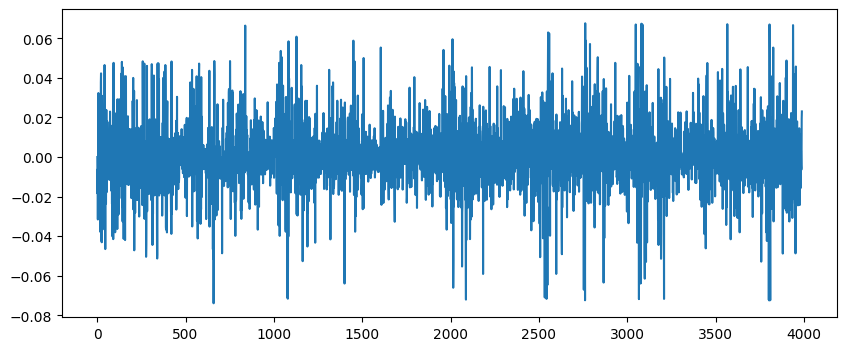

In [ ]:
df['log_return_close'].plot(figsize=(10,4))


In [ ]:
from statsmodels.tsa.stattools import adfuller
adf = adfuller(df['log_return_close'].dropna())
print("ADF statistic:", adf[0])
print("p-value:", adf[1])


ADF statistic: -62.06491279737907
p-value: 0.0


<Axes: >

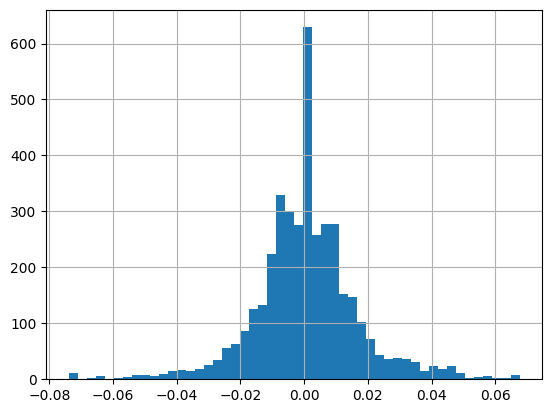

In [ ]:
df['log_return_close'].hist(bins=50)


In [ ]:
df['log_return_close'].skew()
df['log_return_close'].kurtosis()


np.float64(2.855285313615777)

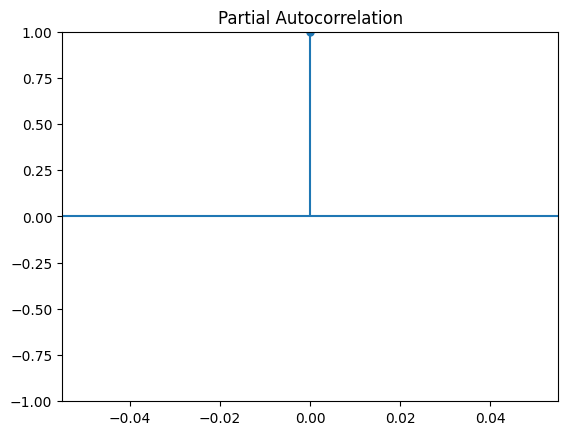

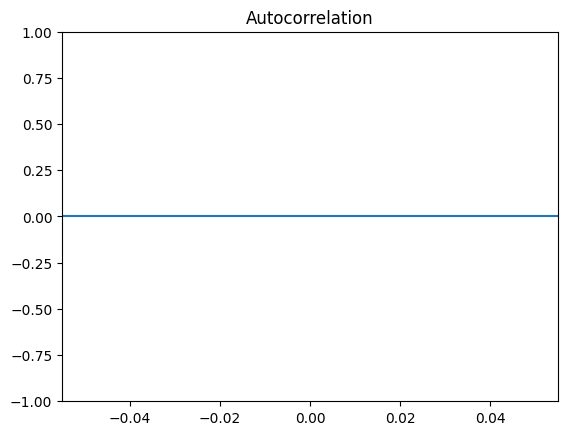

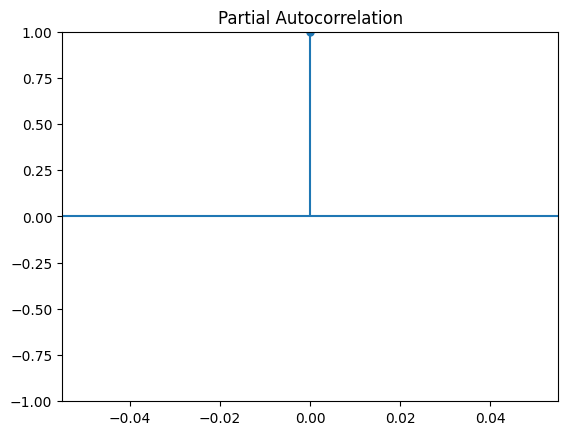

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['log_return_close'], lags=30)
plot_pacf(df['log_return_close'], lags=30)


## 1. Log Price

In [ ]:
df['log_price'] = np.log(df['Close'])
y = df['log_price'].values

## 2. Kalman Filter (FIX, Q, R)

In [ ]:
from pykalman import KalmanFilter
F = np.array([[1, 1],
              [0, 1]])

kf = KalmanFilter(
    transition_matrices=F,
    observation_matrices=[[1, 0]],
    transition_covariance=np.diag([1e-4, 1e-5]),   # ⬅ FIX: cho phép trend & slope động
    observation_covariance=1e-4,                   # ⬅ FIX: tin dữ liệu hơn
    initial_state_mean=[y[0], 0],
    initial_state_covariance=np.eye(2)
)

state_means, state_covs = kf.smooth(y)

df['trend'] = state_means[:, 0]
df['slope'] = state_means[:, 1]

## 3. Dự báo với Uncertainly

In [ ]:
n_forecast = 10
last_state = state_means[-1]
last_cov = state_covs[-1]

forecast_state = last_state.copy()
forecast_cov = last_cov.copy()

means, vars_ = [], []

for _ in range(n_forecast):
    forecast_state = F @ forecast_state
    forecast_cov = F @ forecast_cov @ F.T + kf.transition_covariance
    
    means.append(forecast_state[0])
    vars_.append(forecast_cov[0, 0])


### Back to Price

In [ ]:
mean_price = np.exp(means)
upper = np.exp(np.array(means) + 2 * np.sqrt(vars_))
lower = np.exp(np.array(means) - 2 * np.sqrt(vars_))

## 4. Regime detection (slope)

In [ ]:
if df['slope'].iloc[-1] > 0:
    print("📈 Uptrend regime")
else:
    print("📉 Downtrend regime")

📈 Uptrend regime


## 5. Trực quan hóa

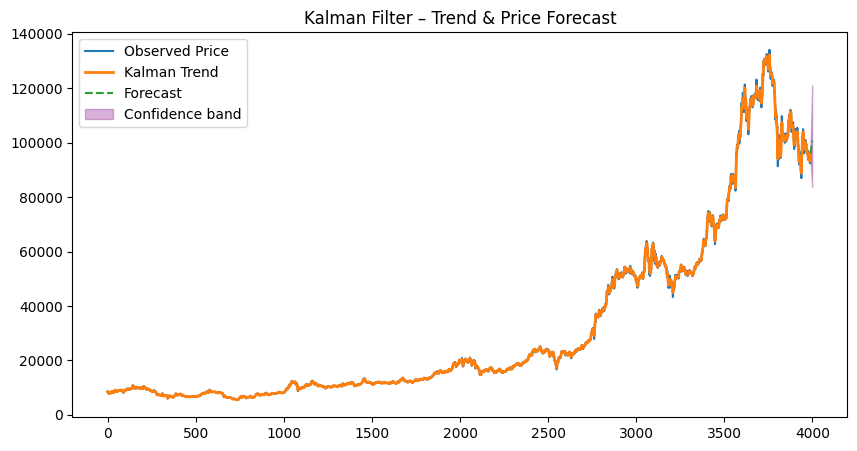

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df['Close'], label='Observed Price')
plt.plot(np.exp(df['trend']), label='Kalman Trend', linewidth=2)

forecast_index = range(len(df), len(df) + n_forecast)
plt.plot(forecast_index, mean_price, label='Forecast', linestyle='--')
plt.fill_between(forecast_index, lower, upper, alpha=0.3, label='Confidence band', color = 'purple')

plt.legend()
plt.title("Kalman Filter – Trend & Price Forecast")
plt.show()

## 6. Các chỉ số đánh giá

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox

### Giá trị thực & Dự báo

In [ ]:
y_true = np.log(df['Close'].values[1:])      # log-price thực
y_pred = df['trend'].values[:-1]             # Kalman dự báo 1-step

### 1. Nhóm sai số dự báo

#### MAE, MSE, RMSE

In [ ]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

#### MAPE & sMAPE

In [ ]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
smape = np.mean(
    2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))
) * 100

### 2. So sánh với Benchmark (RANDOM WALK)

#### Naive forecast (Random Walk)

In [ ]:
y_naive = np.log(df['Close'].values[:-1])
rmse_naive = np.sqrt(mean_squared_error(y_true, y_naive))

#### Theil’s U statistic

In [ ]:
theils_u = rmse / rmse_naive

### 3. Log - Likelihood, AIC, BIC 

#### Log-likelihood từ Kalman

In [ ]:
loglik = kf.loglikelihood(y_true)

#### AIC & BIC

In [ ]:
n = len(y_true)
k = 5  # số tham số ước lượng (Q, R, initial states...)

aic = -2 * loglik + 2 * k
bic = -2 * loglik + k * np.log(n)


### 4. Kiểm tra phần dư

#### Residuals 

In [ ]:
residuals = y_true - y_pred

#### Mean Residuals (Bias Check)

In [ ]:
residual_mean = np.mean(residuals)

#### White Noise

In [ ]:
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

### 5. Đánh giá Regime/ Trend

#### Slope cuối kỳ

In [ ]:
last_slope = df['slope'].iloc[-1]

regime = "Uptrend" if last_slope > 0 else "Downtrend"


### 6. Kết quả đánh giá

In [ ]:
metrics = pd.DataFrame({
    "Metric": [
        "MAE", "RMSE", "MAPE (%)", "sMAPE (%)",
        "RMSE Naive", "Theil's U",
        "Log-Likelihood", "AIC", "BIC",
        "Residual Mean", "Trend Regime"
    ],
    "Value": [
        mae, rmse, mape, smape,
        rmse_naive, theils_u,
        loglik, aic, bic,
        residual_mean, regime
    ]
})

metrics


,Metric,Value
0,MAE,0.009199
1,RMSE,0.013177
2,MAPE (%),0.093192
3,sMAPE (%),0.093196
4,RMSE Naive,0.016601
5,Theil's U,0.793792
6,Log-Likelihood,10323.227362
7,AIC,-20636.454723
8,BIC,-20604.999497
9,Residual Mean,0.000606
